In [1]:
import os
import time
import itertools

from torchvision.transforms import v2
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# from PIL import Image
from tqdm import tqdm
# import mediapy as media

%load_ext autoreload
%autoreload 2
from vae_model import *
from ph_dataset import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# torchvision.disable_beta_transforms_warning()

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <38796DC6-8F33-3A89-BBAA-5FC71F99817A> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints a

In [2]:
# Training helper functions
def make_training_loss_plot(log_dict, figsize=(9,6)):
    """Plot training loss vs step"""
    epoch = log_dict['Epoch'][-1]
    log_df = pd.DataFrame.from_dict(log_dict)
    plt.figure(figsize=figsize)
    sns.lineplot(
        log_df,
        x='Step',
        y='Loss',
        errorbar=None,
    )
    ax = plt.gca()
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    plt.grid(True, which="both", ls="-")
    plt.title(f'Training Loss After {epoch} Epochs')
    plt.show()

def get_device(verbose=False):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    if verbose: print(f"Using device {device}")
    return device

def show_dataset_sample(dataset, nrows=5, ncols=15):
    nsamples = nrows * ncols
    idxs = np.arange(len(dataset))
    sample_idxs = np.random.choice(idxs, nsamples, replace=False)
    
    if len(sample_idxs) < nsamples:
        print('Not enough training data')

    f = plt.figure(figsize=(ncols*1.2, nrows*2))
    f.tight_layout()

    canvas = np.zeros((nrows * 16, ncols * 16))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        ph_data = ph_dataset.get_ph_data(idx)
        canvas[row*16:(row+1)*16, col*16:(col+1)*16] = ph_data['img']

    img_plt = plt.imshow(canvas, cmap='rocket')
    plt.colorbar(img_plt, fraction=0.045)
    # 
    # plt.imshow(canvas, cmap='icefire')
    plt.title("Pulse Height Dataset Sample")
    plt.show(f)
    plt.close(f)

In [3]:
# Forward method
def vae_forward(
    vae: BetaVAE,
    X: torch.Tensor,
    beta: float,
    sparsity_weight:float,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        X: (N, C, 16, 16) input tensor of Cx16x16 images

    Returns:
        (,) vae loss.
    """
    # Apply positional encoding to input coordinates
    vae.train()
    recon_x, mu, logvar = vae.forward(X)
    return beta_vae_loss_function(recon_x, X, mu, logvar, beta=beta, sparsity_weight=sparsity_weight)

# Sampling method
@torch.inference_mode()
def vae_sample(
    vae: BetaVAE,
    nsamples: int,
    img_cwh: tuple[int, int],
    seed: int,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        nsamples: number of images to create
        img_cwh: image dimensions (W, H)
    Returns:
        (,) 
    """
    vae.eval()
    device = get_device()
    with torch.no_grad():
        torch.manual_seed(seed)
        z = torch.randn(nsamples, vae.latent_dim).to(device)
        return vae.decode(z).cpu()

In [4]:
# VaeWrapper: one level of indirection to make experimentation on the fly easier

class VaeWrapper(nn.Module):
    def __init__(
        self,
        vae: BetaVAE,
        input_img_cwh: tuple[int, int] = (1, 16, 16),
        seed: int = 180,
        beta=1.0,
        sparsity_weight=0.0,
    ):
        super().__init__(),
        self.vae = vae
        self.img_cwh = input_img_cwh
        self.seed = seed
        self.beta = beta
        self.sparsity_weight = sparsity_weight
        
    def forward(self, X: torch.Tensor):
        """
        Args:
            X: (N, C, 16, 16) input tensor of C x 16 x 16 images

        Returns:
            (,) VAE loss.
        """
        self.vae.train()
        assert X[0].shape == torch.Size(self.img_cwh), f"X.shape={X.shape} but img_cwh={self.img_cwh}"
        return vae_forward(self.vae, X, self.beta, self.sparsity_weight)

    @torch.inference_mode()
    def sample(
        self,
        nsamples: int = 16,
    ):
        self.vae.eval()
        return vae_sample(self.vae, nsamples, self.img_cwh, self.seed)

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Define a function to extract latent space representations
def extract_latent_space(vae_model, data_loader, device=get_device()):
    """
    Extract latent space representations from the VAE.
    
    Args:
        vae_model: Trained VAE model.
        data_loader: DataLoader containing images to process.
        device: PyTorch device (e.g., 'cuda' or 'cpu').

    Returns:
        latent_representations: List of latent vectors.
    """
    vae_model.eval()  # Set model to evaluation mode
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            
            # Pass images through encoder
            mu, logvar = vae_model.encode(images)
            z = vae_model.reparameterize(mu, logvar)  # Get latent vector
            
            latent_representations.append(z.cpu().numpy())
    
    # Combine all latent vectors and labels
    latent_representations = np.concatenate(latent_representations, axis=0)
    return latent_representations

# Dimensionality reduction and clustering
def perform_clustering(latent_vectors, method='tsne', n_components=2, n_clusters=9):
    """
    Reduce the dimensionality of latent space and perform clustering.
    
    Args:
        latent_vectors: Array of latent vectors (N x D).
        method: Dimensionality reduction method ('pca' or 'tsne').
        n_components: Number of dimensions to reduce to (default 2).
    
    Returns:
        reduced_data: Latent vectors reduced to n_components dimensions.
        cluster_labels: Cluster assignments from KMeans.
    """
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, perplexity=30, random_state=42)
    else:
        raise ValueError("Unsupported method. Use 'pca' or 'tsne'.")
    
    reduced_data = reducer.fit_transform(latent_vectors)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Adjust number of clusters as needed
    cluster_labels = kmeans.fit_predict(reduced_data)
    
    return reduced_data, cluster_labels

# Visualization
def visualize_clusters(reduced_data, cluster_labels, true_labels=None):
    """
    Visualize the clusters in 2D.
    
    Args:
        reduced_data: 2D array of reduced latent space vectors.
        cluster_labels: Cluster assignments from KMeans.
        true_labels: Ground truth labels (optional).
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Cluster ID')
    plt.title('Latent Space Clustering')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    if true_labels is not None:
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=true_labels, cmap='jet', alpha=0.5, s=10)
        plt.colorbar(label='True Label')
        plt.title('Latent Space Clustering with Ground Truth')
    
    plt.show()

# Example usage
# if __name__ == "__main__":
#     # Assume `vae_model`, `data_loader`, and `device` are predefined
#     latent_vectors, true_labels = extract_latent_space(vae_model, data_loader, device)
#     reduced_data, cluster_labels = perform_clustering(latent_vectors, method='tsne')
#     visualize_clusters(reduced_data, cluster_labels, true_labels)

In [6]:
# Training function for VAE model

def train_vae(
    train_config,
    ph_dataset,
    img_cwh = (1, 16, 16),
    seed = 180,
    verbose=True,
):
    device = get_device()
    ### Create panoseti dataloader
    
    train_loader = torch.utils.data.DataLoader(
        dataset = ph_dataset,
        batch_size = train_config['batch_size'],
        shuffle=False,
    )
    if verbose:
        show_dataset_sample(ph_dataset, nrows=5, ncols=15)
    
    ### Model training config
    in_channels = img_cwh[0]
    model = VaeWrapper(
        vae = train_config['model'](
            in_channels,
            hidden_dim = train_config['hidden_dim'],
            latent_dim = train_config['latent_dim'],
        ),
        input_img_cwh = img_cwh,
        seed = seed,
        beta = train_config['beta'],
        sparsity_weight = train_config['sparsity_weight'],
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'], weight_decay=train_config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=train_config['gamma'])

    ### Train Model
    log_dict = {
        'Step': [],
        'Loss': [],
        'Epoch': []
    }
    os.makedirs('vae_model_checkpoints', exist_ok=True)
    
    step = 0
    for epoch in range(1, train_config['num_epochs'] + 1):
        torch.manual_seed(seed + epoch)
        
        for x in tqdm(train_loader, unit="batch"):
            step += 1
            model.train()
            x = x.to(device)

            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()
    
            if step % 5 == 0: 
                log_dict['Epoch'].append(epoch)
                log_dict['Step'].append(step)
                log_dict['Loss'].append(np.abs(loss.item()))
        
        # Update learning rate
        scheduler.step()

        
        # Make figures for this Epoch
        print(f'Epoch {epoch}\n')
        
        if (epoch - 1) % 5 == 0:
            print('current lr = ', scheduler.get_lr())
            make_training_loss_plot(log_dict)
            plot_sample(model)

            latent_vectors = extract_latent_space(model.vae, train_loader)
            reduced_data, cluster_labels = perform_clustering(latent_vectors, method='tsne')
            visualize_clusters(reduced_data, cluster_labels)
            # make_training_loss_plot()
        if (epoch - 1) % 20 == 0:
            # make_training_loss_plot(log_dict)
            torch.save(model, f"vae_model_checkpoints/vae2_nepoch={epoch}_ldim={train_config['latent_dim']}")

    log_df = pd.DataFrame.from_dict(log_dict)
    make_training_loss_plot(log_dict)
    plot_sample(model)
    return model, log_df

In [7]:
def plot_sample(model: VaeWrapper, nrows=5, ncols=15, size=16):
    nsamples = nrows * ncols
    sampled_images = model.sample(nsamples = nsamples)
    assert len(sampled_images) == nrows * ncols
    imgs = np.zeros((nrows * size, ncols * size))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        
        curr = sampled_images[i, 0, ...].reshape(size, size)
        imgs[row*size:(row+1)*size, col*size:(col+1)*size] = curr.numpy()
    plt.figure(figsize=(15, 5))
    plt.imshow(imgs, cmap='rocket', vmin = 0, vmax=1)
    plt.show()

In [8]:
# ph_dataset_config = {
#     "data_dir": './test_data',
#     "run_dir": 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd',
#     "module_ids": 'all',
# }

ph_dataset_config = {
    "data_dir": './test_data',
    "run_dir": 'obs_Lick.start_2023-10-12T04:28:34Z.runtype_eng-test.pffd',
    "module_ids": 'all',
}

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ToDtype(torch.float),
])

ph_dataset = PulseHeightDataset(ph_dataset_config, transform=transform, log_level=logging.ERROR)

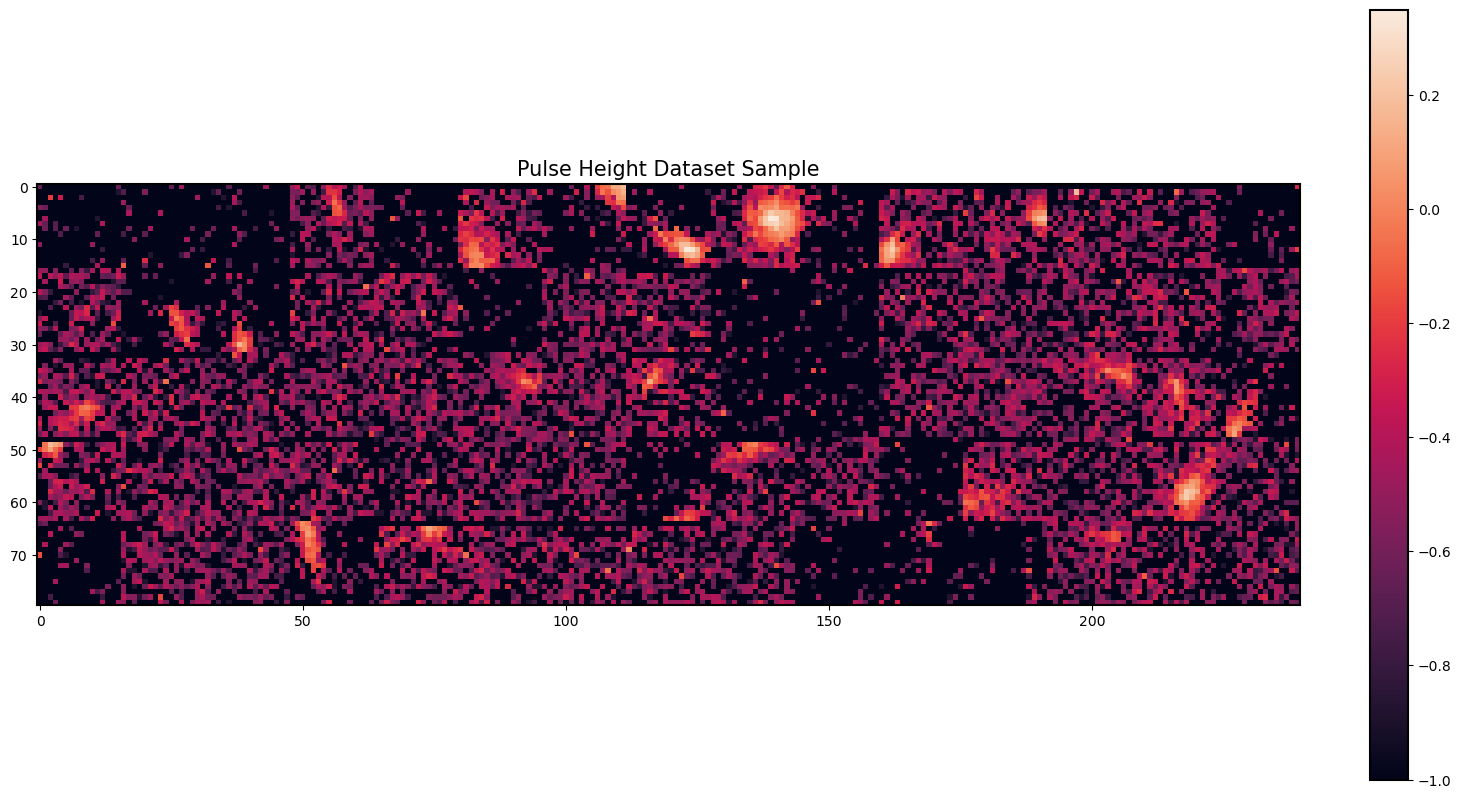

100%|██████████████████████████████████████| 111/111 [00:03<00:00, 34.53batch/s]


Epoch 1

current lr =  [0.0001]


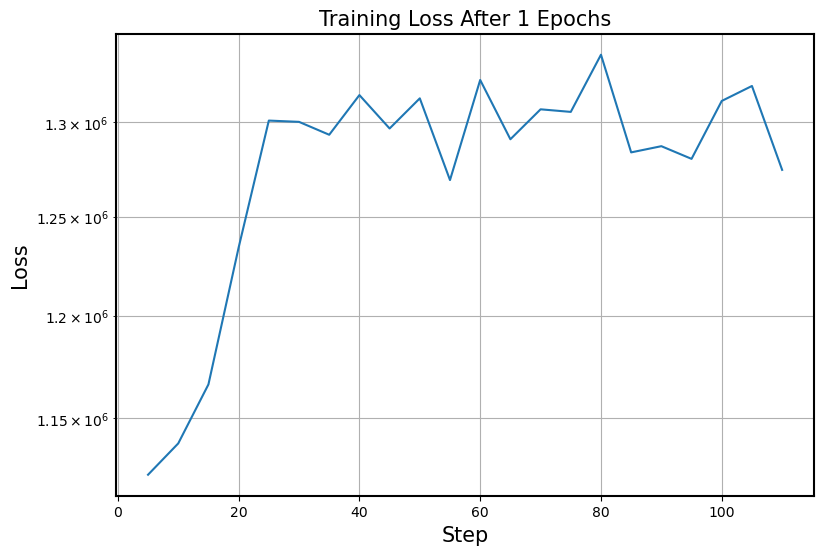

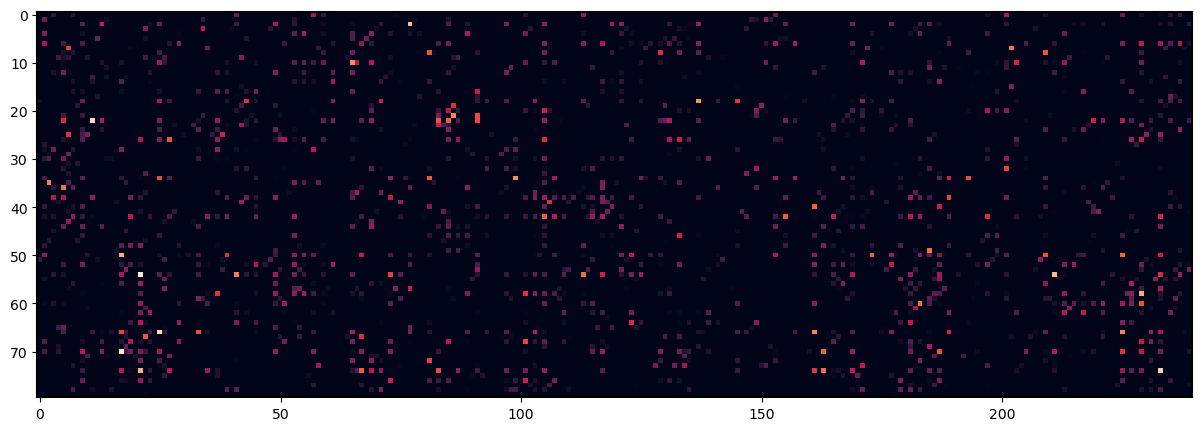

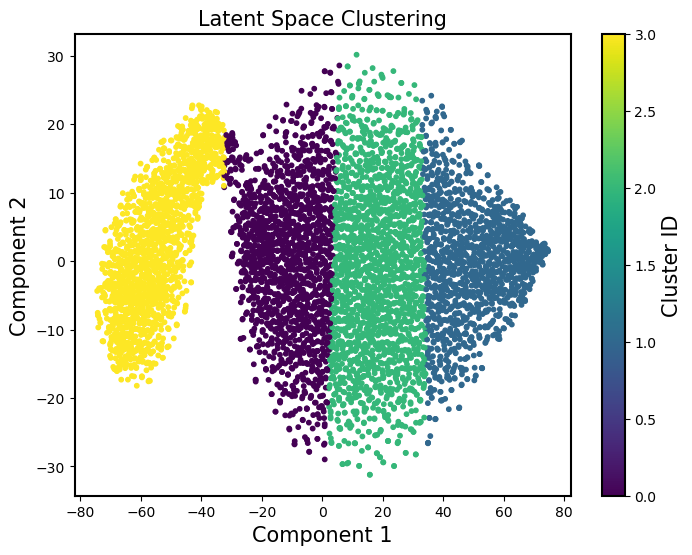

100%|██████████████████████████████████████| 111/111 [00:02<00:00, 40.50batch/s]


Epoch 2



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 40.61batch/s]


Epoch 3



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.75batch/s]


Epoch 4



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.40batch/s]


Epoch 5



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.49batch/s]


Epoch 6

current lr =  [0.0001]


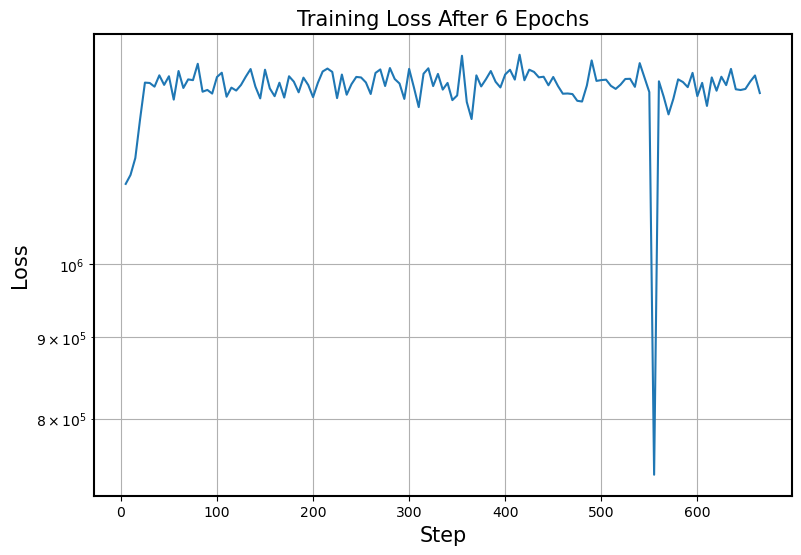

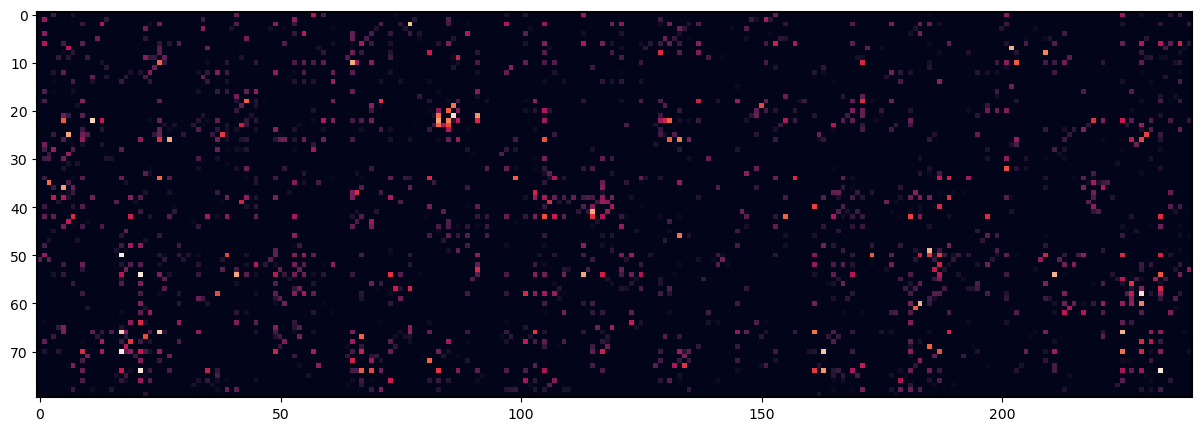

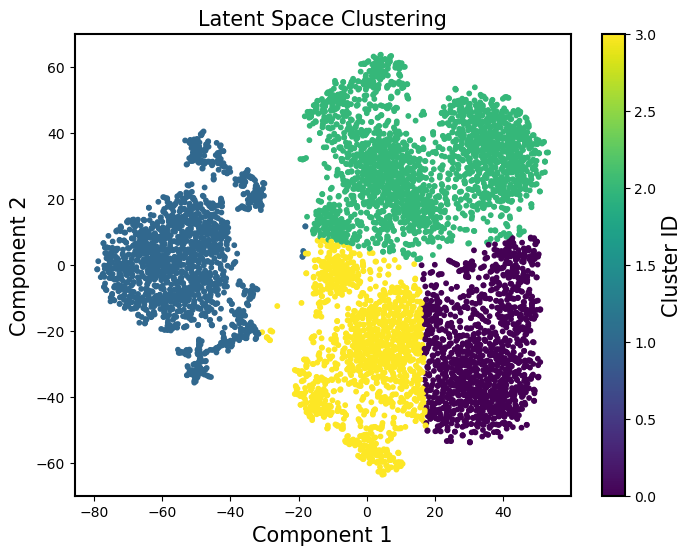

100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.03batch/s]


Epoch 7



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 39.89batch/s]


Epoch 8



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.75batch/s]


Epoch 9



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.23batch/s]


Epoch 10



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.39batch/s]


Epoch 11

current lr =  [0.0001]


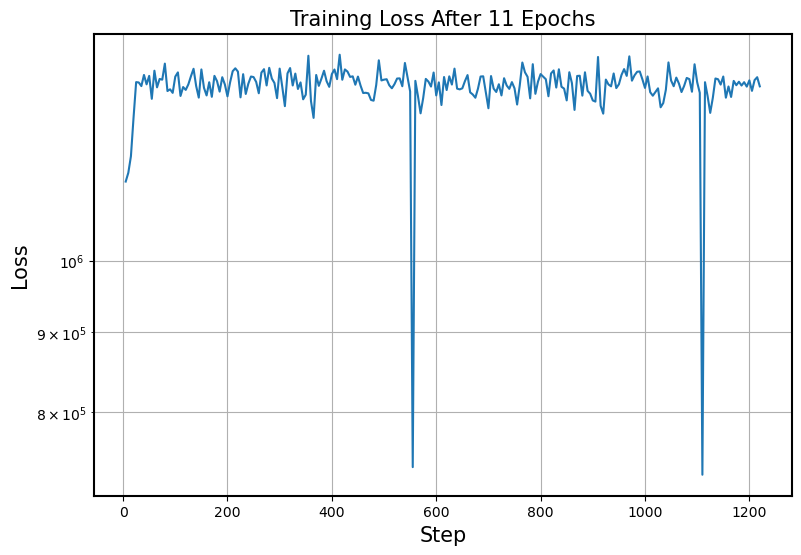

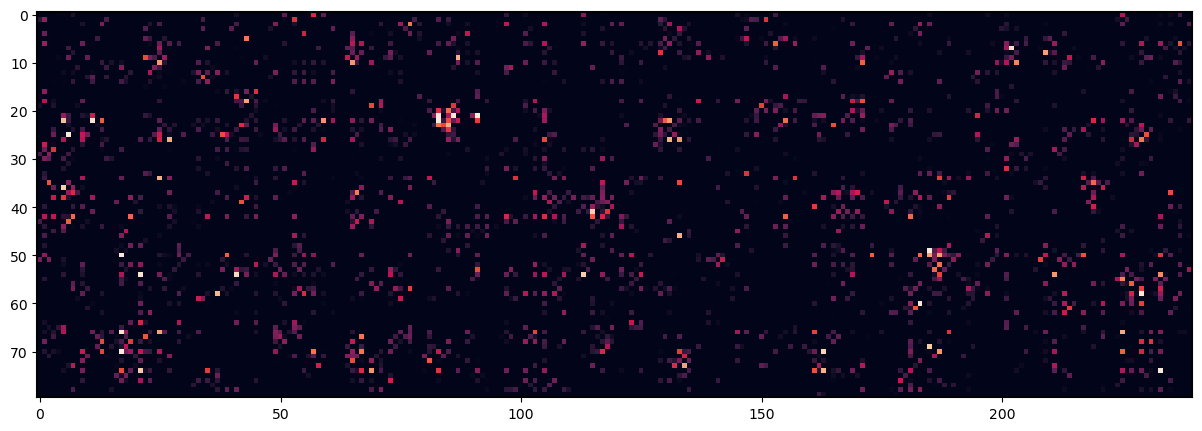

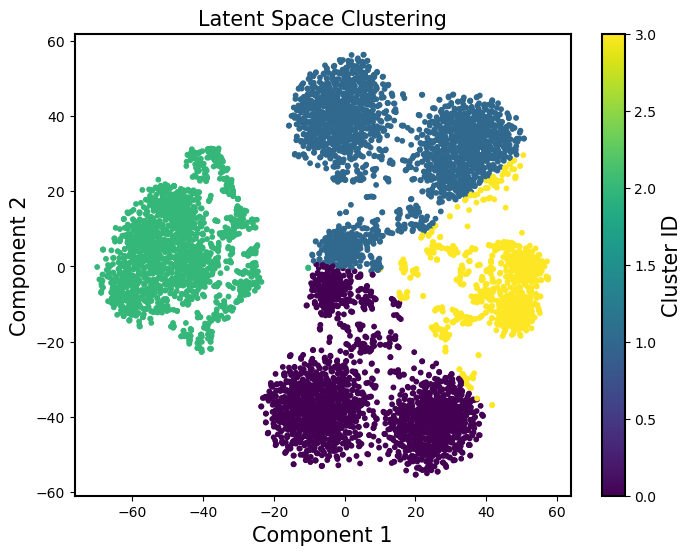

100%|██████████████████████████████████████| 111/111 [00:02<00:00, 39.71batch/s]


Epoch 12



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 39.48batch/s]


Epoch 13



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.28batch/s]


Epoch 14



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.61batch/s]


Epoch 15



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.68batch/s]


Epoch 16

current lr =  [0.0001]


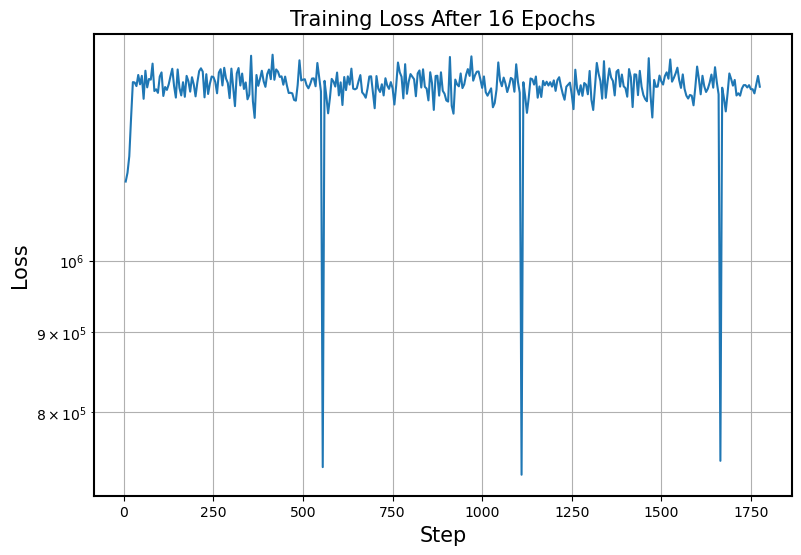

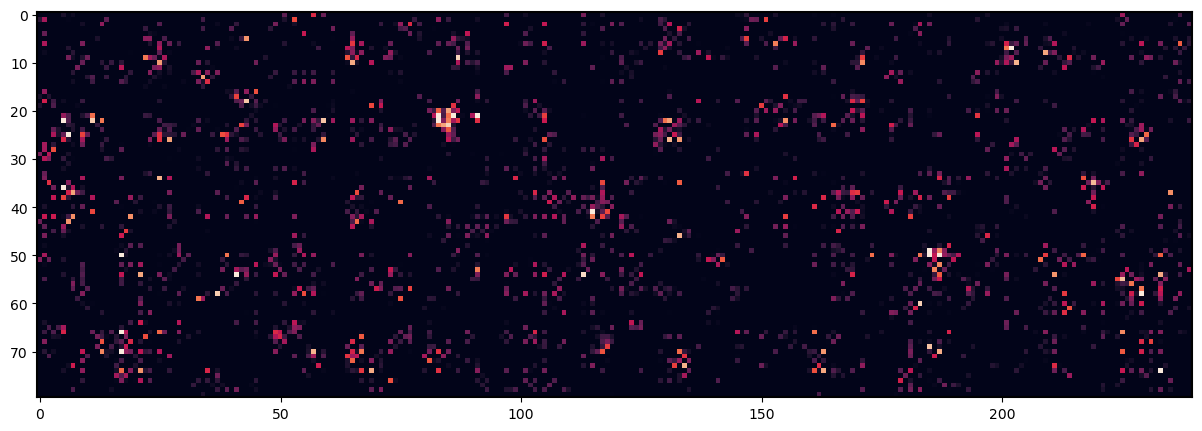

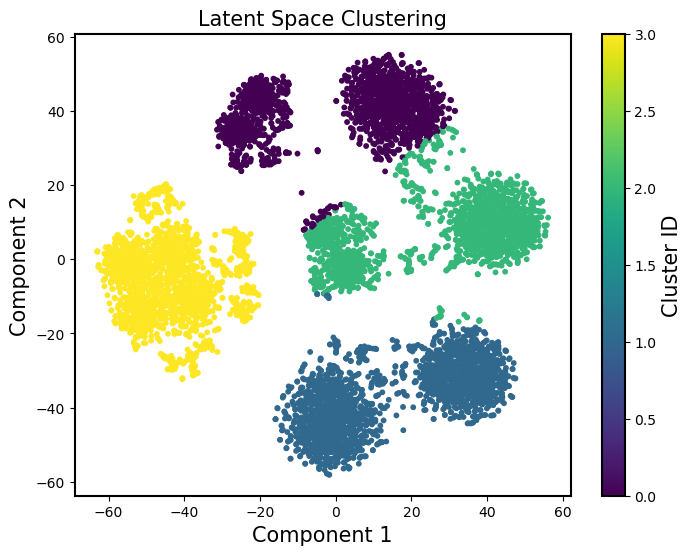

100%|██████████████████████████████████████| 111/111 [00:02<00:00, 39.47batch/s]


Epoch 17



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 39.68batch/s]


Epoch 18



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.28batch/s]


Epoch 19



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.03batch/s]


Epoch 20



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.87batch/s]


Epoch 21

current lr =  [0.0001]


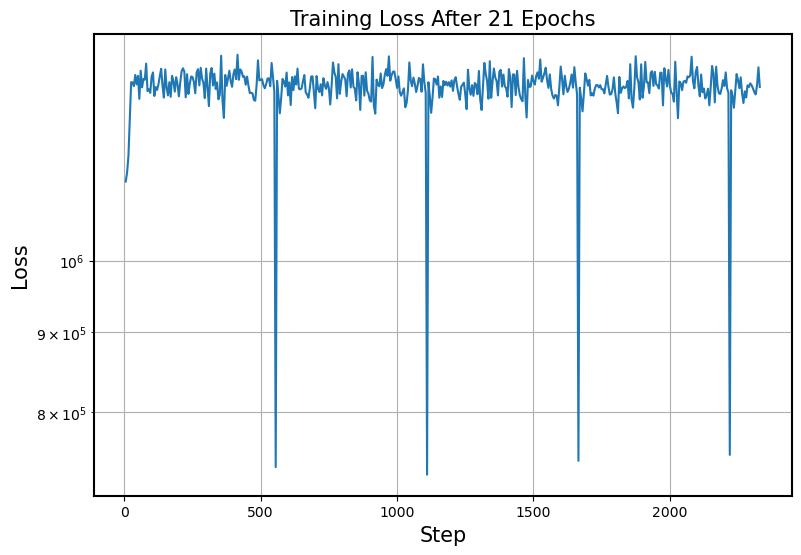

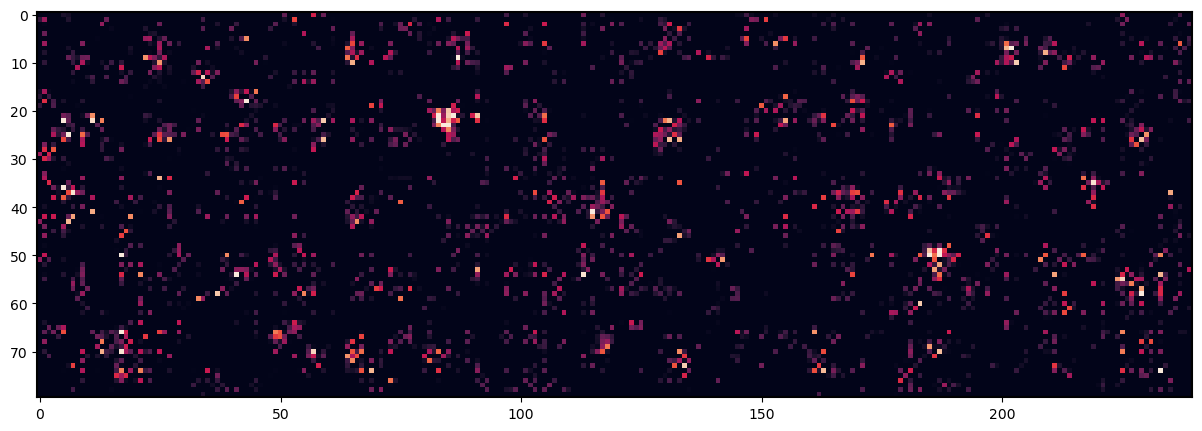

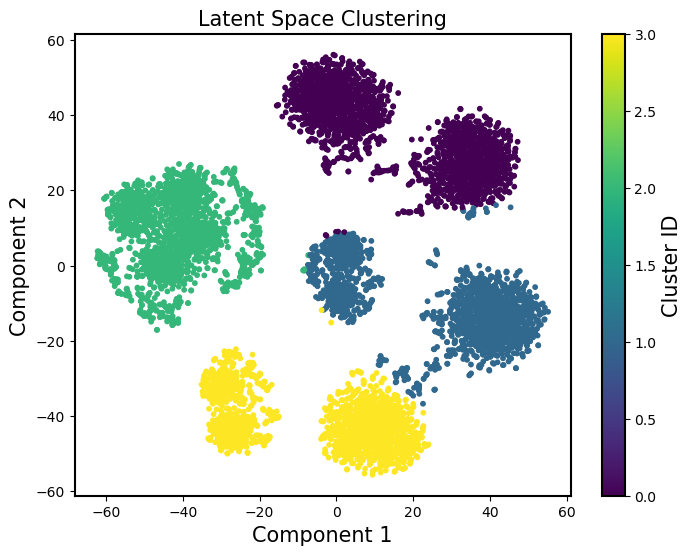

100%|██████████████████████████████████████| 111/111 [00:03<00:00, 36.04batch/s]


Epoch 22



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 38.96batch/s]


Epoch 23



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 40.89batch/s]


Epoch 24



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.30batch/s]


Epoch 25



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.26batch/s]


Epoch 26

current lr =  [0.0001]


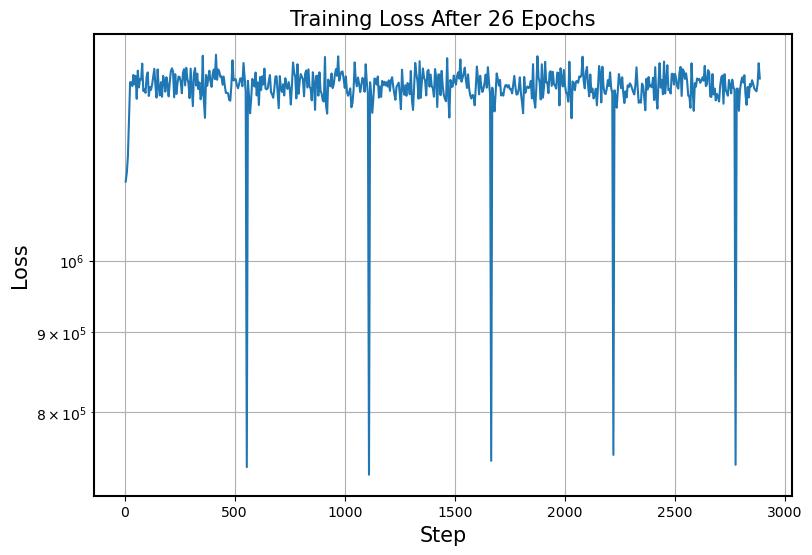

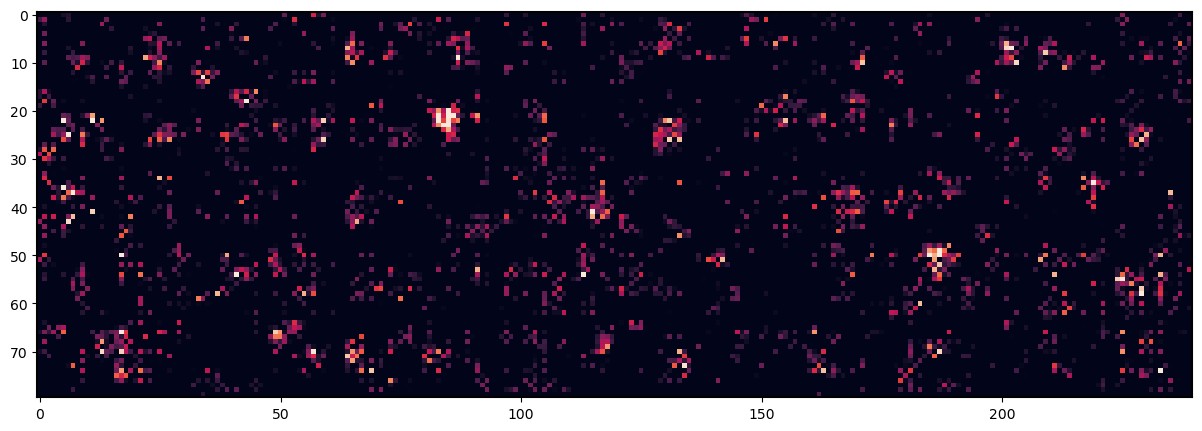

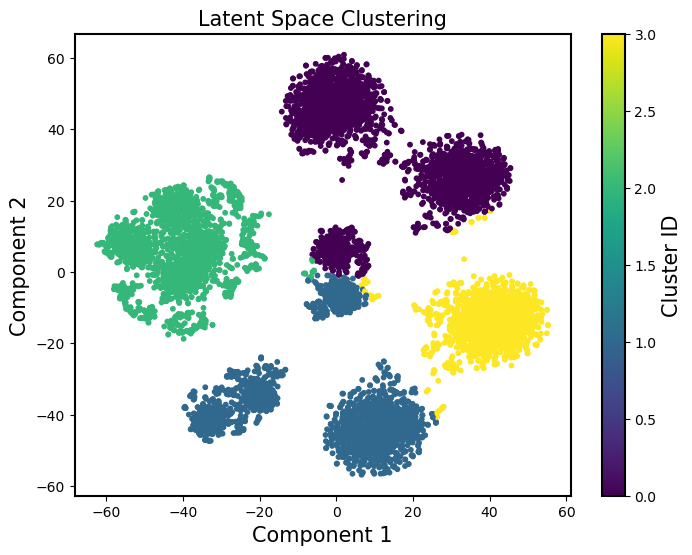

100%|██████████████████████████████████████| 111/111 [00:02<00:00, 39.77batch/s]


Epoch 27



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 39.28batch/s]


Epoch 28



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 40.09batch/s]


Epoch 29



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 39.98batch/s]


Epoch 30



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.22batch/s]


Epoch 31

current lr =  [0.0001]


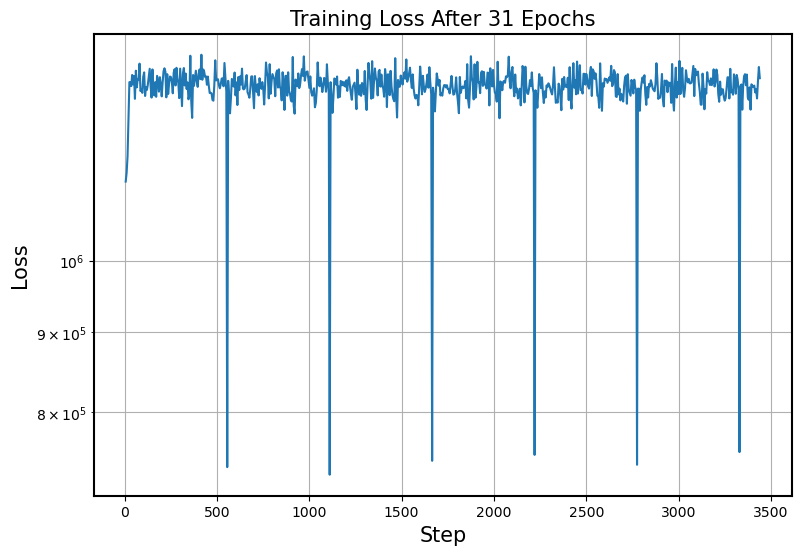

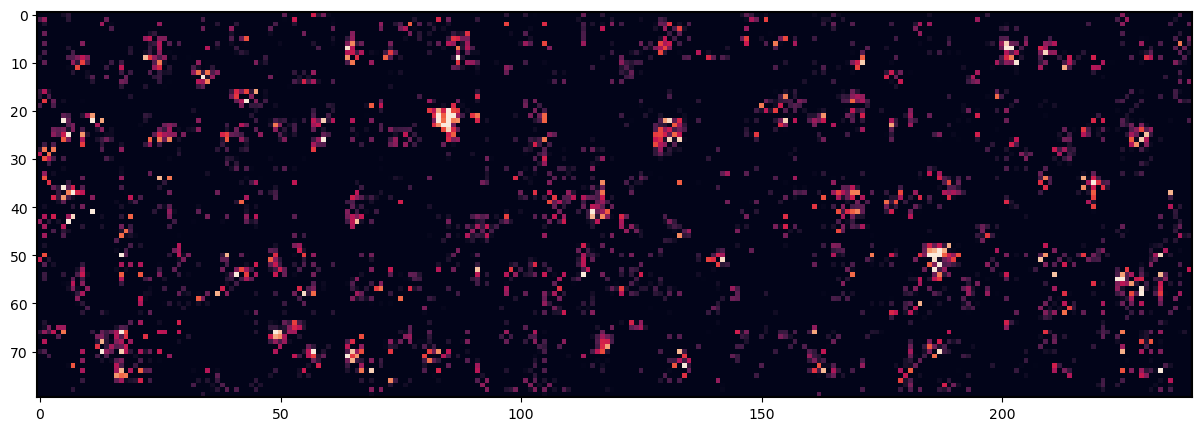

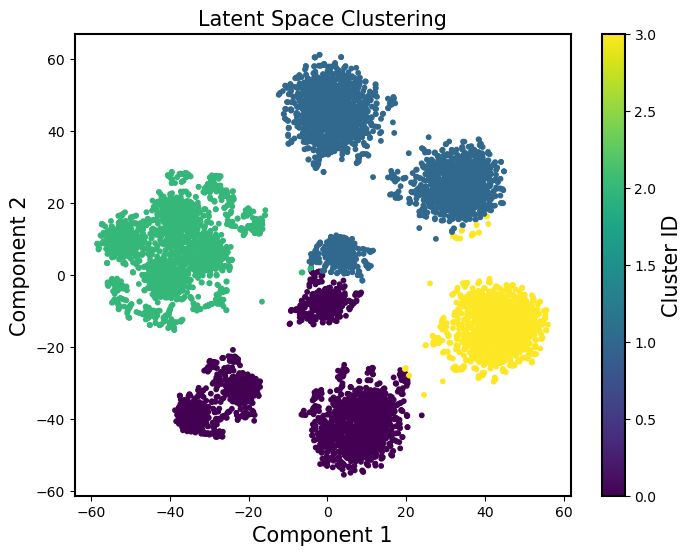

100%|██████████████████████████████████████| 111/111 [00:02<00:00, 40.80batch/s]


Epoch 32



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 40.20batch/s]


Epoch 33



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.34batch/s]


Epoch 34



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.66batch/s]


Epoch 35



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.73batch/s]


Epoch 36

current lr =  [0.0001]


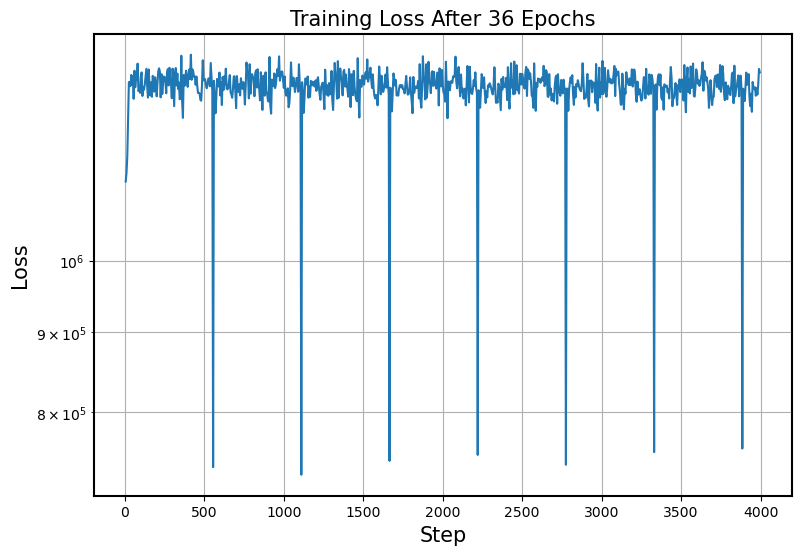

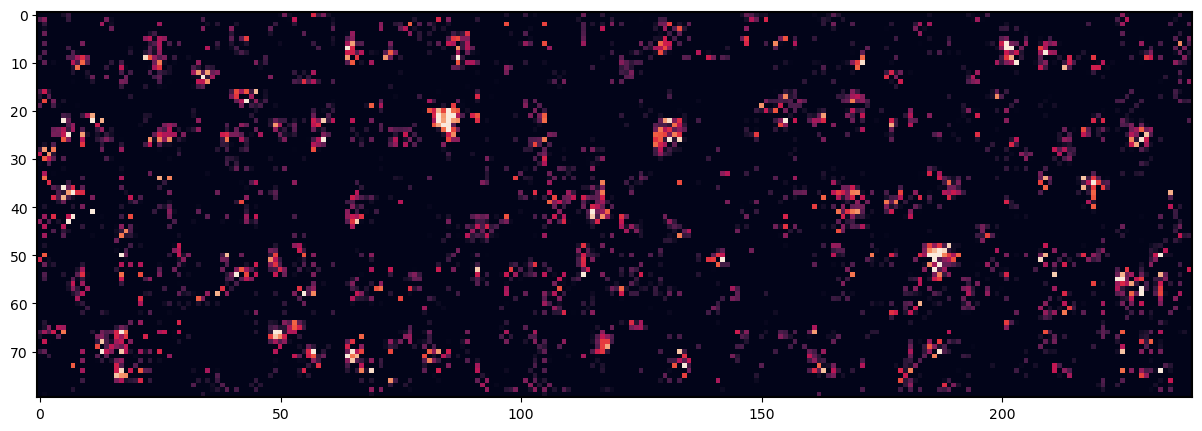

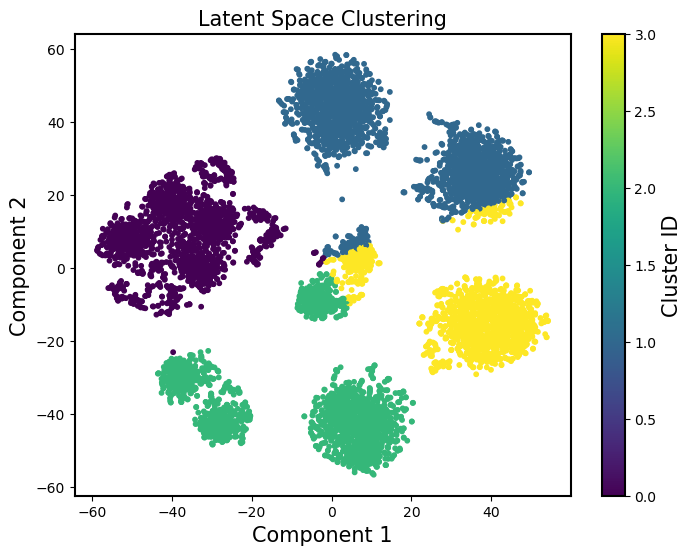

100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.73batch/s]


Epoch 37



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 40.96batch/s]


Epoch 38



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.39batch/s]


Epoch 39



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.21batch/s]


Epoch 40



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.48batch/s]


Epoch 41

current lr =  [0.0001]


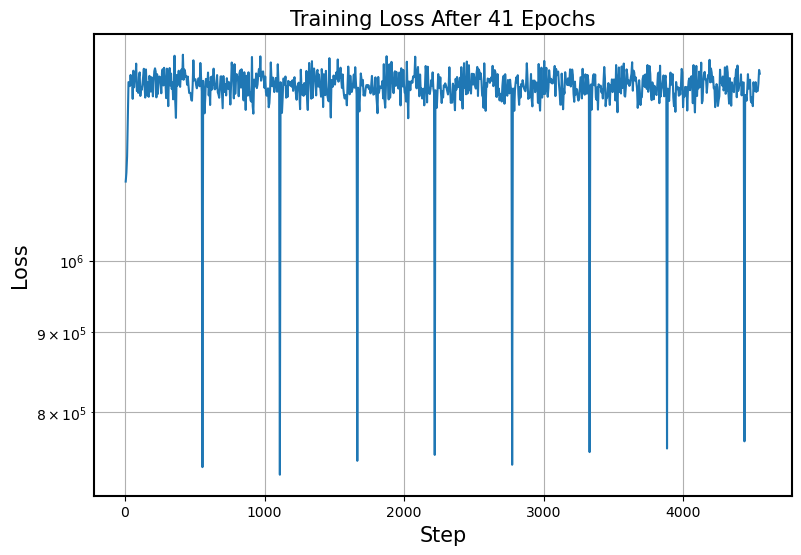

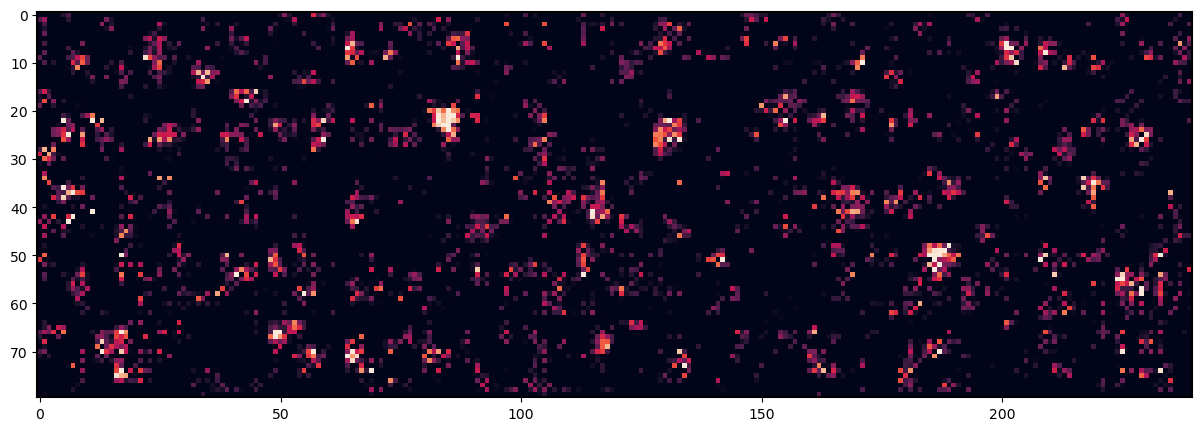

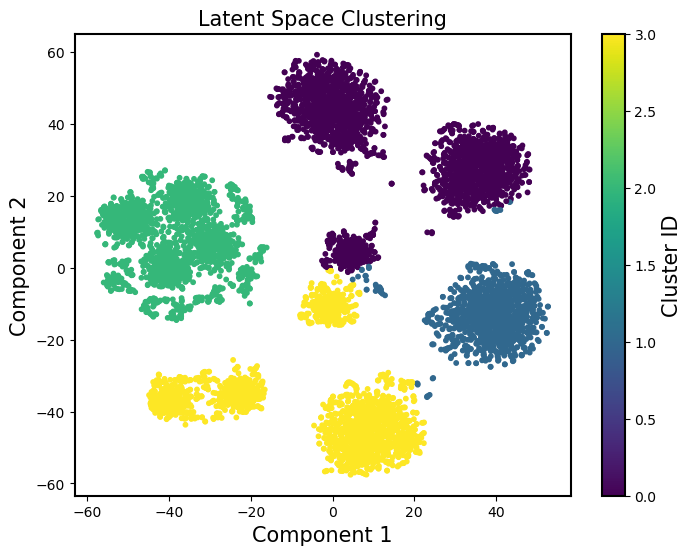

100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.63batch/s]


Epoch 42



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 41.30batch/s]


Epoch 43



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 39.68batch/s]


Epoch 44



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.44batch/s]


Epoch 45



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 42.45batch/s]


Epoch 46

current lr =  [0.0001]


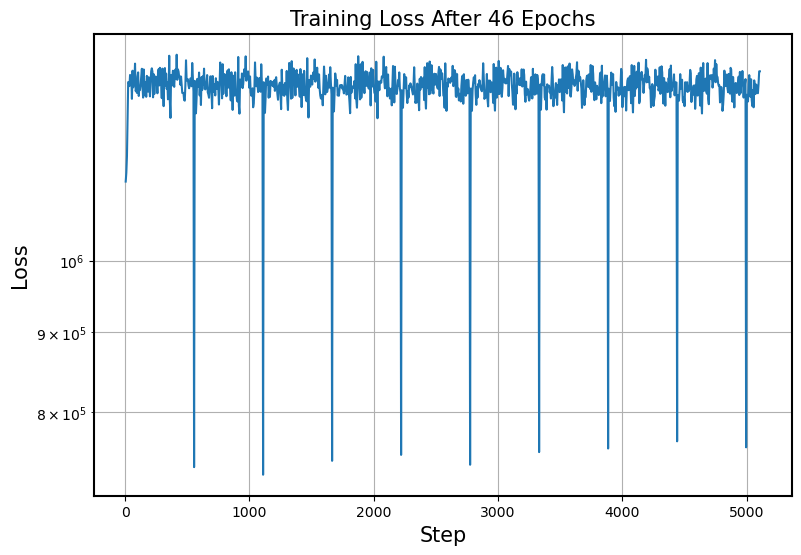

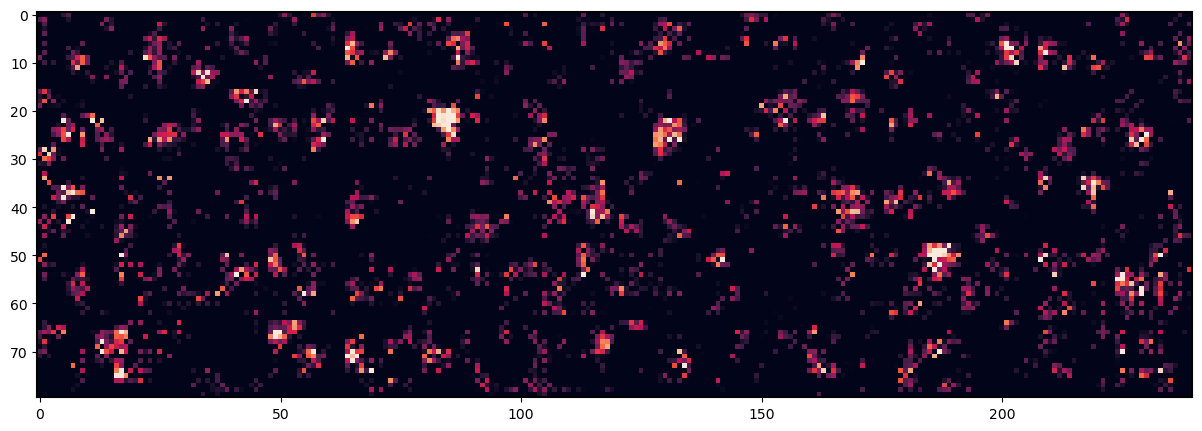

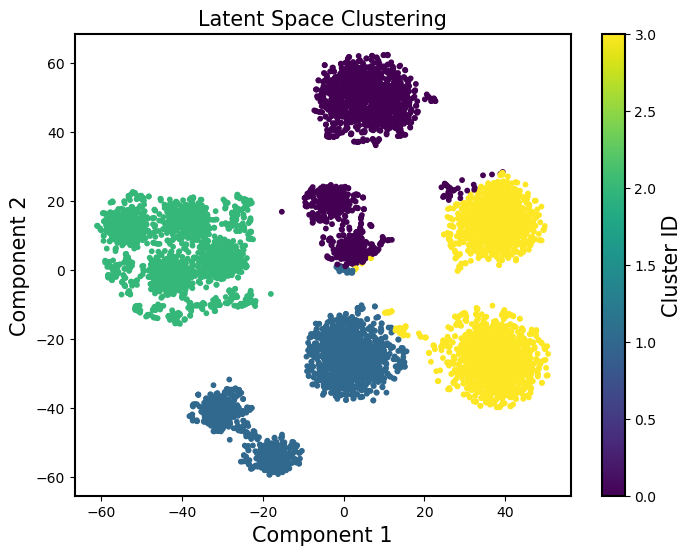

100%|██████████████████████████████████████| 111/111 [00:02<00:00, 51.03batch/s]


Epoch 47



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 51.16batch/s]


Epoch 48



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 52.49batch/s]


Epoch 49



100%|██████████████████████████████████████| 111/111 [00:02<00:00, 52.52batch/s]


Epoch 50



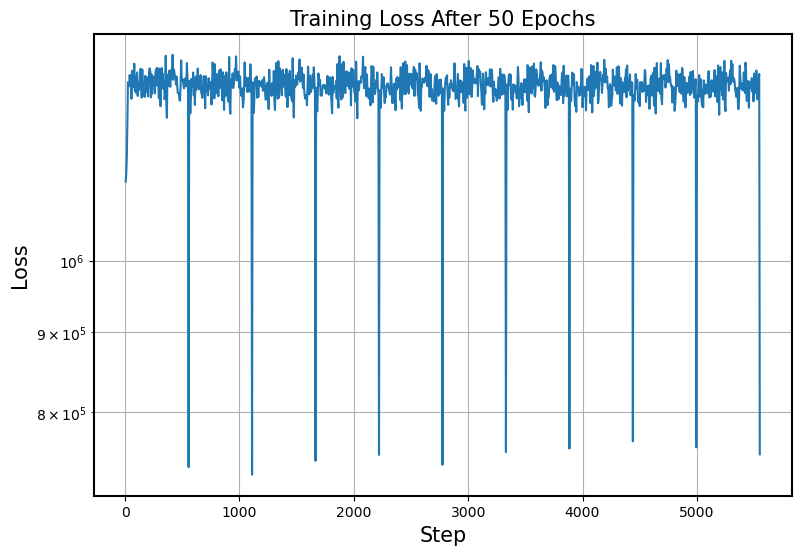

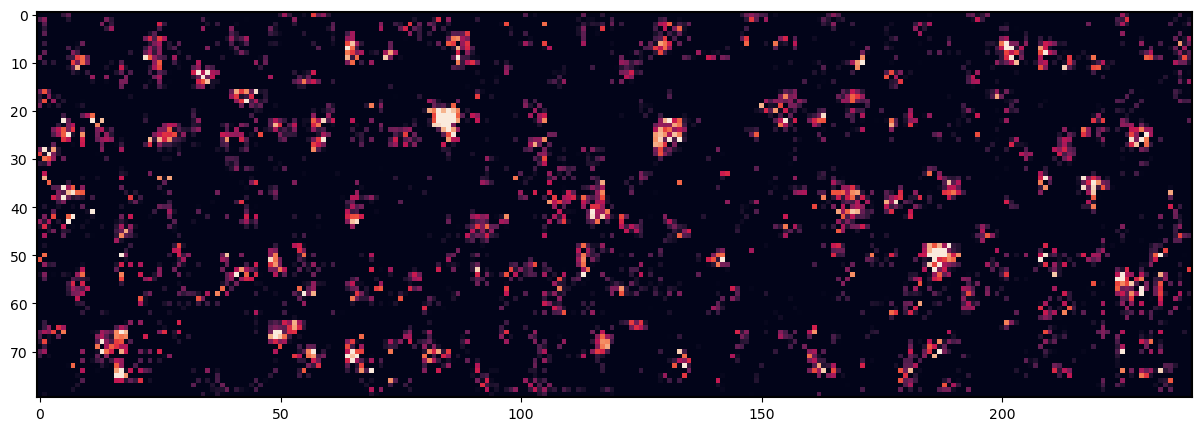

In [9]:
train_config = {
    'model': BetaVAE,
    'hidden_dim': 64,
    'latent_dim': 32,
    'beta': 1.0,
    'sparsity_weight': 1e-4,
    'num_epochs': 50,
    'batch_size': 64,
    'gamma': 1.0,
    'lr': 1e-4,
    'weight_decay': 0,
}

model, log_df = train_vae(
    train_config,
    ph_dataset, 
    img_cwh = (1, 16, 16),
    seed = 15,
    verbose = True
)